In [263]:
# 延用上週爬取的股價資料，完成本次作業要求：
# 1. 計算技術指標（SMA、RSI、MACD）
# 2. 可視化 K 線圖
# 3. 技術指標結合機器學習（線性回歸、決策樹、隨機森林）預測股價漲跌。使用技術指標作為特徵來預測第 n 天的股價

### 1-1. 準備資料：爬取歷年股價資料

In [264]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import requests, json
import plotly.graph_objects as go

In [265]:
# 爬取股價資料
def fetch_stock_data(code, year, month):
    if len(str(month)) == 1:
        month = '0' + str(month)
    query_interval = str(year) + str(month) + '01'
    url = f'https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date={query_interval}&stockNo={code}'
    html = requests.get(url)
    content = json.loads(html.text)
    if content['total'] != 0:
        stock_data = content['data']
        col_name = content['fields']
        # 預先新增一個西元年欄位, 把民國年換成西元年
        df = pd.DataFrame(data=stock_data, columns=col_name)
        df['西元年'] = df['日期'].str[:3].astype('int') + 1911
        df['日期'] = df['西元年'].astype('str') + df['日期'].str[3:]
        # 將日期轉成datetime格式
        df['日期'] = pd.to_datetime(df['日期'])
        df.drop(columns=['西元年'], inplace=True)
        return df
    else:
        print(f"查無資料: {code} - {year} / {month}")
        return None
    
n = 2
target_code = '1301'
# 爬取近 n 年股價資料
def fetch_stock_data_years(code, n):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(weeks=52*n)
    data = []
    for year in range(start_date.year, end_date.year + 1):
        if year == end_date.year:
            for month in range(1, end_date.month + 1):
                print(f"爬取資料: {code} - {year} / {month}")
                df = fetch_stock_data(code, year, month)
                if df is not None:
                    data.append(df)
        else:
            for month in range(1, 13):
                print(f"爬取資料: {code} - {year} / {month}")
                df = fetch_stock_data(code, year, month)
                if df is not None:
                    data.append(df)
    return pd.concat(data)


df = fetch_stock_data_years(target_code, n)
df['成交股數'] = df['成交股數'].str.replace(',', '').astype(int)
df['成交金額'] = df['成交金額'].str.replace(',', '').astype(int)
df['開盤價'] = df['開盤價'].str.replace(',', '').astype(float)
df['最高價'] = df['最高價'].str.replace(',', '').astype(float)
df['最低價'] = df['最低價'].str.replace(',', '').astype(float)
df['收盤價'] = df['收盤價'].str.replace(',', '').astype(float)
df['成交筆數'] = df['成交筆數'].str.replace(',', '').astype(int)


爬取資料: 1301 - 2022 / 1
爬取資料: 1301 - 2022 / 2
爬取資料: 1301 - 2022 / 3
爬取資料: 1301 - 2022 / 4
爬取資料: 1301 - 2022 / 5
爬取資料: 1301 - 2022 / 6
爬取資料: 1301 - 2022 / 7
爬取資料: 1301 - 2022 / 8
爬取資料: 1301 - 2022 / 9
爬取資料: 1301 - 2022 / 10
爬取資料: 1301 - 2022 / 11
爬取資料: 1301 - 2022 / 12
爬取資料: 1301 - 2023 / 1
爬取資料: 1301 - 2023 / 2
爬取資料: 1301 - 2023 / 3
爬取資料: 1301 - 2023 / 4
爬取資料: 1301 - 2023 / 5
爬取資料: 1301 - 2023 / 6
爬取資料: 1301 - 2023 / 7
爬取資料: 1301 - 2023 / 8
爬取資料: 1301 - 2023 / 9
爬取資料: 1301 - 2023 / 10
爬取資料: 1301 - 2023 / 11
爬取資料: 1301 - 2023 / 12
爬取資料: 1301 - 2024 / 1
爬取資料: 1301 - 2024 / 2
爬取資料: 1301 - 2024 / 3
爬取資料: 1301 - 2024 / 4
爬取資料: 1301 - 2024 / 5
爬取資料: 1301 - 2024 / 6
爬取資料: 1301 - 2024 / 7
爬取資料: 1301 - 2024 / 8
爬取資料: 1301 - 2024 / 9
爬取資料: 1301 - 2024 / 10


In [266]:
df.head()

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
0,2022-01-03,5840396,615088633,105.0,106.0,104.5,105.5,+1.50,2498
1,2022-01-04,5489087,575198247,105.5,106.0,104.5,105.0,-0.50,2754
2,2022-01-05,5882459,615986416,104.5,105.5,104.0,105.5,+0.50,2591
3,2022-01-06,6381700,676459288,105.5,106.5,105.0,106.5,+1.00,3280
4,2022-01-07,5028344,531411929,106.5,107.0,105.0,105.5,-1.00,2343


### 1-2. 準備資料： 加入技術指標


In [267]:
# 1. 計算技術指標（SMA、RSI、MACD）
def calculate_sma(data, period):
    return data['收盤價'].rolling(window=period).mean()

sma5 = calculate_sma(df, 5)
sma10 = calculate_sma(df, 10)
sma20 = calculate_sma(df, 20)


In [268]:
def calculate_rsi(data, period):
    delta = data['收盤價'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

rsi = calculate_rsi(df, 14)

In [269]:
def calculate_macd(data, slow=26, fast=12, signal=9):
    exp1 = data['收盤價'].ewm(span=fast, adjust=False).mean()
    exp2 = data['收盤價'].ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    return macd, macd_signal

macd, macd_signal = calculate_macd(df, 26, 12, 9)


### 1-3. 準備資料：可視化 K 線圖

In [270]:
# 2. 可視化 K 線圖
df['SMA5'] = sma5
df['SMA10'] = sma10
df['SMA20'] = sma20
df['RSI'] = rsi
df['MACD'] = macd
df['MACD_Signal'] = macd_signal
df.dropna(subset=['SMA5', 'SMA10', 'SMA20','RSI'], inplace=True)

# 移除不需要的欄位 
df.drop(columns=['成交股數', '成交金額', '成交筆數','漲跌價差'], inplace=True)
df.info()

df.to_csv(f'stock_data_{target_code}_with_features.csv', index=False)

current_data = pd.read_csv(f'stock_data_{target_code}_with_features.csv')

# 可視化 K 線圖
def plot_candlestick(data, title):
    fig = go.Figure(data=[go.Candlestick(x=data['日期'],
                                        open=data['開盤價'],
                                        high=data['最高價'],
                                        low=data['最低價'],
                                        close=data['收盤價'],
                                        increasing_line_color='red',
                                        decreasing_line_color='green')])
    
    fig.add_trace(go.Scatter(x=data['日期'], y=data['SMA5'], mode='lines', name='SMA5'))
    fig.add_trace(go.Scatter(x=data['日期'], y=data['SMA10'], mode='lines', name='SMA10'))
    fig.add_trace(go.Scatter(x=data['日期'], y=data['SMA20'], mode='lines', name='SMA20'))
    fig.add_trace(go.Scatter(x=data['日期'], y=data['RSI'], mode='lines', name='RSI'))
    fig.add_trace(go.Scatter(x=data['日期'], y=data['MACD'], mode='lines', name='MACD'))
    fig.add_trace(go.Scatter(x=data['日期'], y=data['MACD_Signal'], mode='lines', name='MACD_Signal'))

    fig.update_layout(title=title, xaxis_title='日期', yaxis_title='價格',width=1200, height=800)
    fig.update_yaxes(autorange=True)
    
    fig.show()


# 把存下來的資料畫出來
plot_candlestick(current_data, f'{target_code} 近{n}年 K 線圖')




<class 'pandas.core.frame.DataFrame'>
Int64Index: 647 entries, 1 to 0
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   日期           647 non-null    datetime64[ns]
 1   開盤價          647 non-null    float64       
 2   最高價          647 non-null    float64       
 3   最低價          647 non-null    float64       
 4   收盤價          647 non-null    float64       
 5   SMA5         647 non-null    float64       
 6   SMA10        647 non-null    float64       
 7   SMA20        647 non-null    float64       
 8   RSI          647 non-null    float64       
 9   MACD         647 non-null    float64       
 10  MACD_Signal  647 non-null    float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 60.7 KB


In [271]:
# 3. 技術指標結合機器學習（線性回歸、決策樹、隨機森林）預測股價漲跌。
# 使用(SMA5, SMA10, SMA20, SMA60, RSI, MACD, MACD_Signal)技術指標作為特徵來預測第 n 天的股價

by_feature = ['SMA5', 'SMA10', 'SMA20', 'RSI', 'MACD', 'MACD_Signal']

# 檢查是否有缺失值
print(current_data[by_feature].isna().sum())

SMA5           0
SMA10          0
SMA20          0
RSI            0
MACD           0
MACD_Signal    0
dtype: int64


In [272]:
current_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647 entries, 0 to 646
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   日期           647 non-null    object 
 1   開盤價          647 non-null    float64
 2   最高價          647 non-null    float64
 3   最低價          647 non-null    float64
 4   收盤價          647 non-null    float64
 5   SMA5         647 non-null    float64
 6   SMA10        647 non-null    float64
 7   SMA20        647 non-null    float64
 8   RSI          647 non-null    float64
 9   MACD         647 non-null    float64
 10  MACD_Signal  647 non-null    float64
dtypes: float64(10), object(1)
memory usage: 55.7+ KB


In [273]:
future_data = current_data.copy()[-1:]
future_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 646 to 646
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   日期           1 non-null      object 
 1   開盤價          1 non-null      float64
 2   最高價          1 non-null      float64
 3   最低價          1 non-null      float64
 4   收盤價          1 non-null      float64
 5   SMA5         1 non-null      float64
 6   SMA10        1 non-null      float64
 7   SMA20        1 non-null      float64
 8   RSI          1 non-null      float64
 9   MACD         1 non-null      float64
 10  MACD_Signal  1 non-null      float64
dtypes: float64(10), object(1)
memory usage: 220.0+ bytes


### 2-1.預測未來 n 天股價: 隨機森林、線性回歸、決策樹

/Users/cfh00900369/Desktop/financial-big-data-analysis/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 38283 (\N{CJK UNIFIED IDEOGRAPH-958B}) missing from current font.

/Users/cfh00900369/Desktop/financial-big-data-analysis/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 30436 (\N{CJK UNIFIED IDEOGRAPH-76E4}) missing from current font.

/Users/cfh00900369/Desktop/financial-big-data-analysis/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 20729 (\N{CJK UNIFIED IDEOGRAPH-50F9}) missing from current font.

/Users/cfh00900369/Desktop/financial-big-data-analysis/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from current font.

/Users/cfh00900369/Desktop/financial-big-data-analysis/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 39640 (\N{CJK UNIFIED 

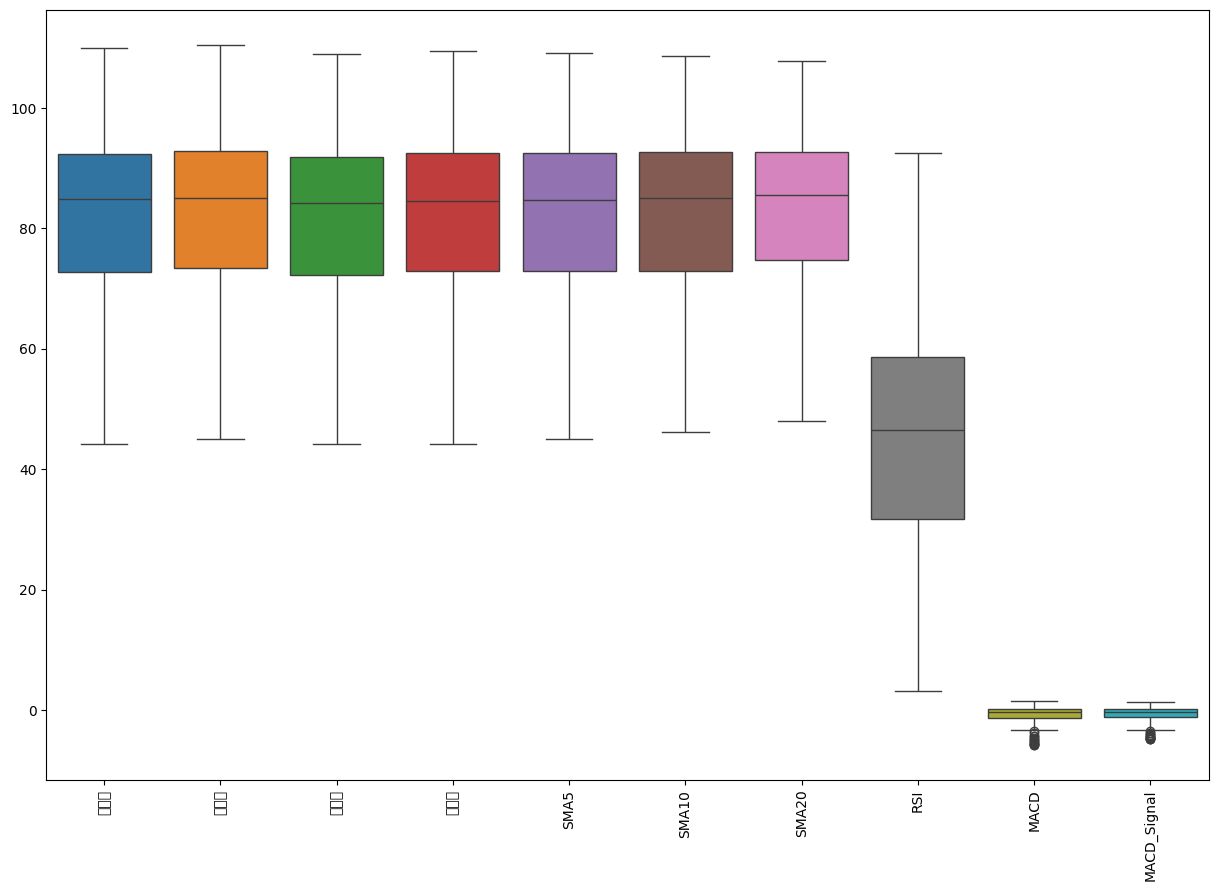

隨機森林 Mean Squared Error: 1.4501688225961584
線性回歸 Mean Squared Error: 0.3254564677961378
決策樹 Mean Squared Error: 2.149956730769231
1301 隨機森林演算法： 未來7天的預測:           日期      開盤價      最高價     最低價      收盤價
0 2024-10-02  52.8670  53.6155  52.065  52.8395
1 2024-10-03  51.2285  52.9940  50.609  52.3230
2 2024-10-04  50.2075  51.0575  49.400  50.2185
3 2024-10-07  52.9340  53.6260  52.127  52.7780
4 2024-10-08  52.5835  53.4130  51.777  52.5495
5 2024-10-09  51.8870  53.1430  51.207  52.4005
6 2024-10-10  53.0630  53.7075  52.294  52.8735
---
1301 線性回歸演算法： 未來7天的預測:           日期           開盤價           最高價           最低價           收盤價
0 2024-10-02     52.851391     53.373008     52.614282     53.319520
1 2024-10-03    127.590564    138.983942    150.545291    156.952612
2 2024-10-04    347.632504    396.461071    434.284496    464.632626
3 2024-10-07    944.480422   1094.929272   1206.383705   1302.247850
4 2024-10-08   2535.418022   2942.313358   3246.483730   3504.989371
5 2024-10-09   6810.37

In [274]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# 預測未來 n 天股價 (n = 7)
predict_days = 7

# 讀取資料
data = pd.read_csv(f'stock_data_{target_code}_with_features.csv')

# 使用箱型圖檢查異常值
plt.figure(figsize=(15, 10))
sns.boxplot(data=data[['開盤價', '最高價', '最低價', '收盤價', 'SMA5', 'SMA10', 'SMA20', 'RSI', 'MACD', 'MACD_Signal']])
plt.xticks(rotation=90)
plt.show()

# 特徵選擇
features = ['SMA5', 'SMA10', 'SMA20', 'RSI', 'MACD', 'MACD_Signal']
target_columns = ['開盤價', '最高價', '最低價', '收盤價']

# 分割資料集
X = data[features]
y = data[target_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 訓練 隨機森林 模型
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 訓練 線性回歸 模型
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 訓練 決策樹 模型
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

# 評估 隨機森林 模型
y_pred = model.predict(X_test)
print(f'隨機森林 Mean Squared Error: {mean_squared_error(y_test, y_pred)}')

# 評估 線性回歸 模型
y_pred_lr = lr_model.predict(X_test)
print(f'線性回歸 Mean Squared Error: {mean_squared_error(y_test, y_pred_lr)}')

# 評估 決策樹 模型
y_pred_dt = dt_model.predict(X_test)
print(f'決策樹 Mean Squared Error: {mean_squared_error(y_test, y_pred_dt)}')

# 預測未來 n 天
def predict_future(data, model, features, n_days):
    future_predictions = []
    last_known_features = data[features].iloc[-1].values.reshape(1, -1)
    
    for _ in range(n_days):
        next_prediction = model.predict(pd.DataFrame(last_known_features, columns=features))
        future_predictions.append(next_prediction[0])
        
        # 更新特徵，假設未來的技術指標不變
        last_known_features = np.roll(last_known_features, -1, axis=1)
        last_known_features[0, -len(next_prediction[0]):] = next_prediction[0]
    
    return future_predictions

future_predictions = predict_future(data, model, features, predict_days)
future_predictions_lr = predict_future(data, lr_model, features, predict_days)
future_predictions_dt = predict_future(data, dt_model, features, predict_days)

# 生成未來 n 天的工作日日期
last_date = pd.to_datetime(data['日期'].iloc[-1])
future_dates = pd.bdate_range(start=last_date, periods=predict_days+1)[1:]  # +1 是因為 bdate_range 包含起始日期

# 將日期與預測結果結合：隨機森林
future_df = pd.DataFrame(future_predictions, columns=target_columns)
future_df['日期'] = future_dates
future_df = future_df[['日期'] + target_columns]
print(f'{target_code} 隨機森林演算法： 未來{predict_days}天的預測: {future_df}\n---')

# 將日期與預測結果結合：線性回歸
future_df_lr = pd.DataFrame(future_predictions_lr, columns=target_columns)
future_df_lr['日期'] = future_dates
future_df_lr = future_df_lr[['日期'] + target_columns]
print(f'{target_code} 線性回歸演算法： 未來{predict_days}天的預測: {future_df_lr}\n---')

# 將日期與預測結果結合：決策樹
future_df_dt = pd.DataFrame(future_predictions_dt, columns=target_columns)
future_df_dt['日期'] = future_dates
future_df_dt = future_df_dt[['日期'] + target_columns]
print(f'{target_code} 決策樹演算法： 未來{predict_days}天的預測: {future_df_dt}')

#### 3-1. 繪製預測資料圖表：繪製函式設定

In [275]:
# 繪製 K 線圖: 通用函式
def plot_combined_candlestick(data, title, subtitle):
    fig = go.Figure(data=[go.Candlestick(x=data['日期'],
                                        open=data['開盤價'],
                                        high=data['最高價'],
                                        low=data['最低價'],
                                        close=data['收盤價'],
                                        increasing_line_color='red',
                                        decreasing_line_color='green')])
    
    fig.add_trace(go.Scatter(x=data['日期'], y=data['SMA5'], mode='lines', name='SMA5', visible='legendonly'))
    fig.add_trace(go.Scatter(x=data['日期'], y=data['SMA10'], mode='lines', name='SMA10', visible='legendonly'))
    fig.add_trace(go.Scatter(x=data['日期'], y=data['SMA20'], mode='lines', name='SMA20', visible='legendonly'))
    fig.add_trace(go.Scatter(x=data['日期'], y=data['RSI'], mode='lines', name='RSI', visible='legendonly'))
    fig.add_trace(go.Scatter(x=data['日期'], y=data['MACD'], mode='lines', name='MACD', visible='legendonly'))
    fig.add_trace(go.Scatter(x=data['日期'], y=data['MACD_Signal'], mode='lines', name='MACD_Signal', visible='legendonly'))

    fig.update_layout(  title={
            'text': f"{title}<br><sup>{subtitle}</sup>",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        }, xaxis_title='日期', yaxis_title='價格', width=1200, height=800,)
    fig.update_xaxes(range=[data['日期'].iloc[-predict_days-14], data['日期'].iloc[-1]])
    fig.update_yaxes(autorange=True)
    fig.show()


In [301]:
# 繪製 收盤價 線圖: 通用函式 用 go.Figure
def plot_closing_price(data, title, subtitle):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data['日期'], y=data['收盤價'], mode='lines', name='收盤價'))
    fig.update_layout(title=title, xaxis_title='日期', yaxis_title='價格', width=1200, height=800)
    fig.update_yaxes(autorange=True)
    fig.add_shape(
        type='line',
        x0=data['日期'].iloc[-predict_days-14],
        x1=0,
        y0=data['收盤價'].iloc[-predict_days-14],
        y1=1,
        line=dict(dash='dash', color='red')
    )
    fig.show()


#### 3-2. 繪製預測資料圖表：隨機森林

In [302]:
combined_data = pd.concat([current_data, future_df], ignore_index=True)
plot_closing_price(combined_data, f'{target_code} future price {predict_days} day prediction', f'time: {datetime.datetime.now().strftime("%Y-%m-%d")}, algorithm: random forest')
plot_combined_candlestick(combined_data, f'{target_code} 歷史資料與未來 {predict_days}天預測 K 線圖', f'製圖時間：{datetime.datetime.now().strftime("%Y-%m-%d")}、演算法：隨機森林')

#### 3-3. 繪製預測資料圖表：線性回歸

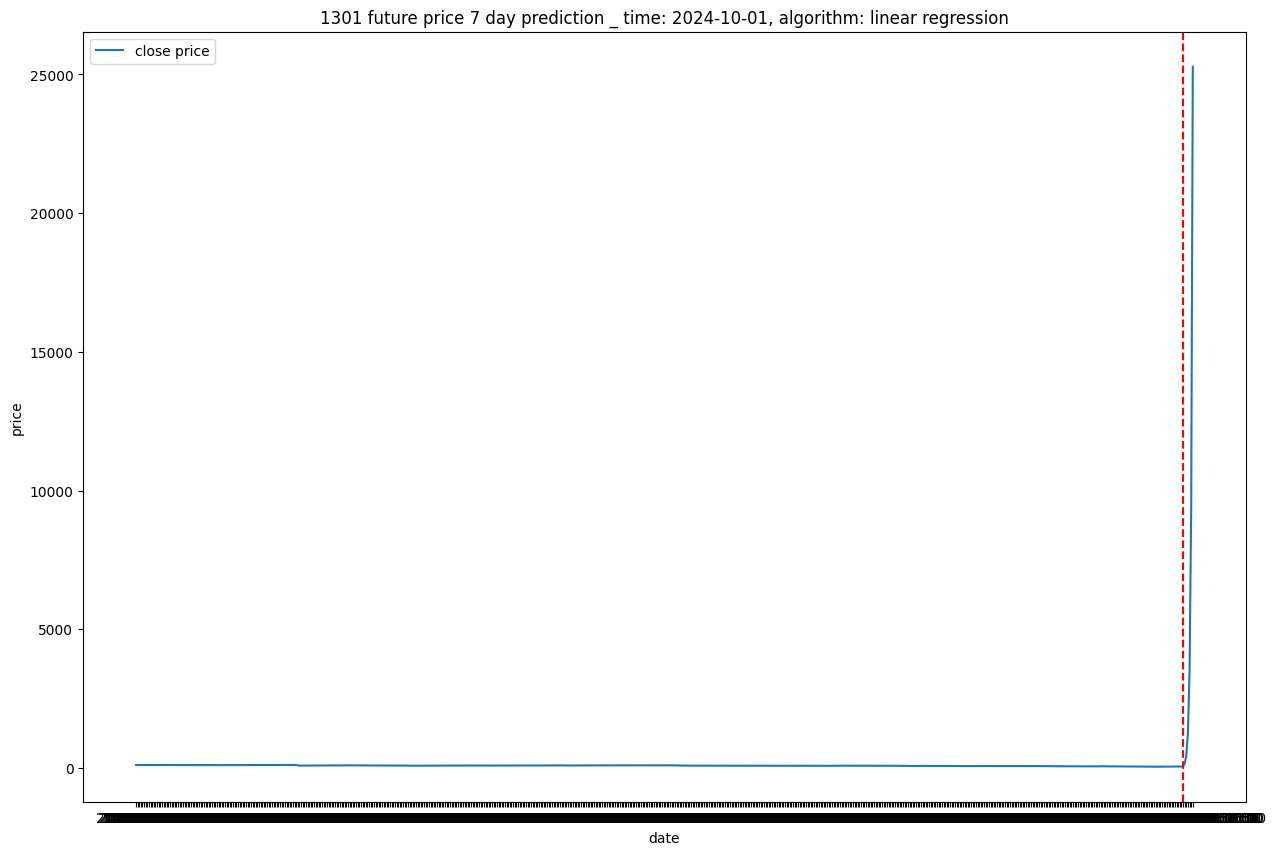

In [281]:
combined_data_lr = pd.concat([current_data, future_df_lr], ignore_index=True)
plot_closing_price(combined_data_lr, f'{target_code} future price {predict_days} day prediction', f'time: {datetime.datetime.now().strftime("%Y-%m-%d")}, algorithm: linear regression')
plot_combined_candlestick(combined_data_lr, f'{target_code} 歷史資料與未來{predict_days}天預測 K 線圖', f'製圖時間：{datetime.datetime.now().strftime("%Y-%m-%d")}、演算法：線性回歸')

#### 3-4. 繪製預測資料圖表：決策樹

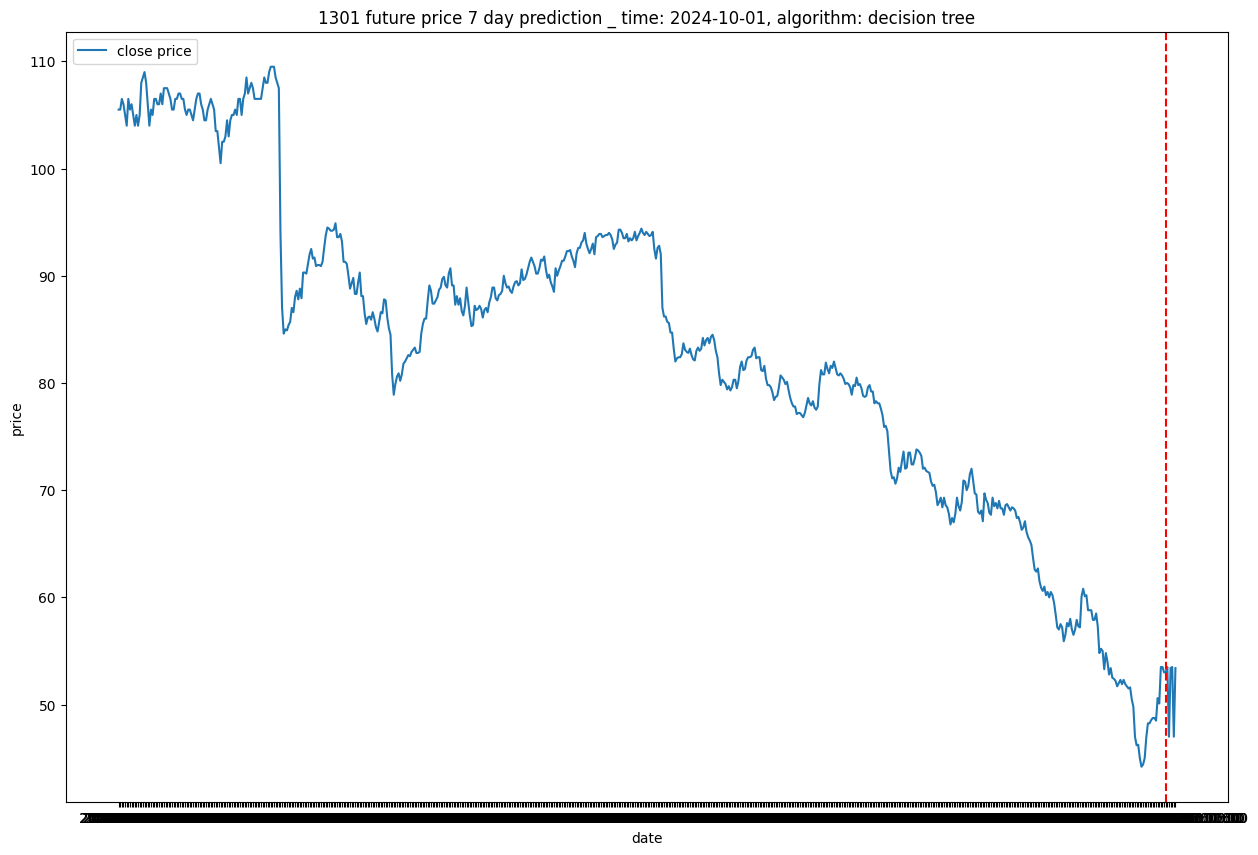

In [282]:
combined_data_dt = pd.concat([current_data, future_df_dt], ignore_index=True)
plot_closing_price(combined_data_dt, f'{target_code} future price {predict_days} day prediction', f'time: {datetime.datetime.now().strftime("%Y-%m-%d")}, algorithm: decision tree')
plot_combined_candlestick(combined_data_dt, f'{target_code} 歷史資料與未來{predict_days}天預測 K 線圖', f'製圖時間：{datetime.datetime.now().strftime("%Y-%m-%d")}、演算法：決策樹')